In [1]:
%matplotlib inline

import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import glob
import os
import cv2

from matplotlib import pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns

from MulticoreTSNE import MulticoreTSNE as MTSNE

In [2]:
def get_input_output_ops(sess, model_path):
    input_key = 'image'
    output_key = 'prediction'
    print('Loading model {}'.format(model_path))
    signature_key = tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY
    meta_graph_def = tf.saved_model.loader.load(
        sess,
        [tf.saved_model.tag_constants.SERVING],
        model_path )
    signature = meta_graph_def.signature_def

    print('Getting tensor names:')
    image_tensor_name = signature[signature_key].inputs[input_key].name
    print('Input tensor: ', image_tensor_name)
    predict_tensor_name = signature[signature_key].outputs[output_key].name
    print('Output tensor:', predict_tensor_name)

    image_op = sess.graph.get_tensor_by_name(image_tensor_name)
    predict_op = sess.graph.get_tensor_by_name(predict_tensor_name)
    print('Input:', image_op.get_shape())
    print('Output:', predict_op.get_shape())
    return image_op, predict_op

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

MODULE_PATH = '../tfhub/snapshots/mobilenet_v2_050_224_1pct/'
# MODULE_PATH = '../tfhub/snapshots/mobilenet_v2_050_224_75pct/'
image_in, predict_op = get_input_output_ops(sess, MODULE_PATH)
_, height, width, _ = image_in.get_shape()

# MODULE_URL = 'https://tfhub.dev/google/imagenet/mobilenet_v2_050_224/feature_vector/1'; MODULE_NAME='MobilenetV2'
# module = hub.Module(MODULE_URL)
# height, width = hub.get_expected_image_size(module)
# print(height, width)
# image_in = tf.placeholder('float', [1, height, width, 3])
# z_op = module(image_in)
# sess.run(tf.global_variables_initializer())

Loading model ../tfhub/snapshots/mobilenet_v2_050_224_1pct/
INFO:tensorflow:Restoring parameters from ../tfhub/snapshots/mobilenet_v2_050_224_1pct/variables/variables
Getting tensor names:
('Input tensor: ', u'Placeholder:0')
('Output tensor:', u'final_result:0')
('Input:', TensorShape([Dimension(None), Dimension(224), Dimension(224), Dimension(3)]))
('Output:', TensorShape([Dimension(None), Dimension(4)]))


In [3]:
# Populate a list of images and labels
# base_dir = '../data/tfhub_ext_val/'
# label_files = {}
# files = []
# labels = []
# for y in range(5):
#     glob_path = os.path.join(base_dir, '{}'.format(y), '*.jpg')
#     glob_list = glob.glob(glob_path)
#     if len(glob_list) > 0:
#         label_files[y] = glob_path
#         files += glob_list
#         labels += [y]*len(glob_list)
        
# f_label_combo = zip(files, labels)
# np.random.shuffle(f_label_combo)
# files, labels = zip(*f_label_combo)

# files = np.asarray(files)
# labels = np.asarray(labels)
# for f, l in zip(files, labels)[:10]:
#     print(f, l)
    

In [4]:
files = np.load('tfhub_val_files.npy')
yhat = []
for f in files:
    img = cv2.imread(f)[:,:,::-1]
    img = cv2.resize(img, dsize=(height, width))
    img = img * (1./255)
    img = np.expand_dims(img, 0)
    
    ypred = sess.run(predict_op, {image_in: img})
    yhat.append(np.argmax(ypred))
#     ypred = sess.run(z_op, {image_in: img})
#     yhat.append(ypred)

yhat = np.asarray(yhat)

In [5]:
# yconcat = np.concatenate(yhat, axis=0)
# print(yconcat.shape)
# manifold = MTSNE(n_jobs=8, n_components=2)
# z_manifold = manifold.fit_transform(yconcat)
# print(z_manifold.shape)

In [6]:
# np.save(file='tfhub_val_mobilenet_z_manifold', arr=z_manifold)
# np.save(file='tfhub_val_labels', arr=labels)
# np.save(file='tfhub_val_files', arr=files)

In [7]:
yhat = np.asarray(yhat)
y = np.load(file='tfhub_val_labels.npy')
y[y==3] = 2
y[y==4] = 3
acc = (yhat == y).mean()
print(acc)

0.6342235828143143


Text(0.5,1,'MobileNet t-SNE\n1% training (Accuracy=63.42%)')

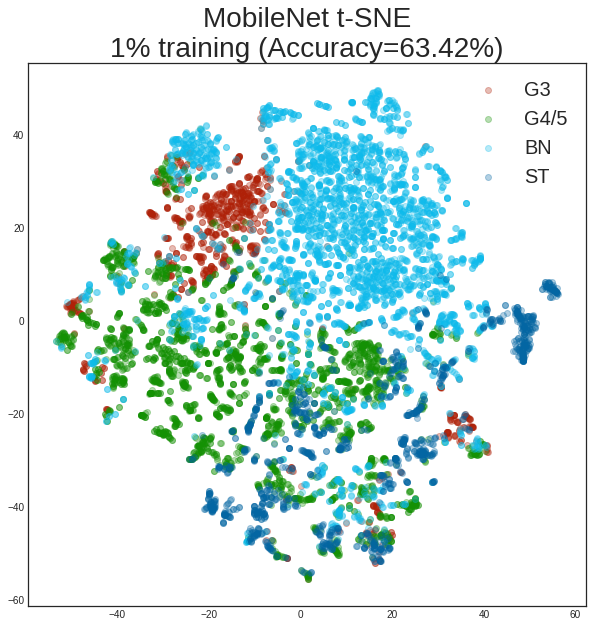

In [8]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
z_precomputed = np.load('tfhub_val_mobilenet_z_manifold.npy')
colors = [ '#af2108', '#149104', '#0ebbeb', '#0366a3']
plot_labels = ['G3', 'G4/5', 'BN', 'ST']
for k in range(4):
    idx = yhat == k
    sns.regplot(z_precomputed[idx,0], z_precomputed[idx, 1],
                fit_reg=False,
                color=colors[k], 
                label=plot_labels[k],
                scatter_kws={'alpha': 0.3})
    
plt.legend(fontsize=20)
plt.title('MobileNet t-SNE\n1% training (Accuracy={:3.2f}%)'.format(acc*100), fontsize=28)